In [1]:
from pathlib import Path

DATA = Path("../data")      # notebooks/ → ../data 로 올라가게
(DATA/"raw").mkdir(parents=True, exist_ok=True)
(DATA/"network").mkdir(parents=True, exist_ok=True)
DATA

PosixPath('../data')

In [2]:
import osmnx as ox
print(ox.__version__)

2.0.6


In [3]:
import osmnx as ox, sys, pathlib
print("OSMnx:", ox.__version__)
print("CWD:", pathlib.Path.cwd())

OSMnx: 2.0.6
CWD: /Users/ieunseo/Desktop/adrenaline-proto/notebooks


In [14]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import osmnx as ox

# --- OSMnx 기본 설정 ---
ox.settings.log_console = True
ox.settings.use_cache = True

# --- 출력 폴더 ---
OUT_DIR = Path("./data/network/jeju_walk")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 1) 제주시 보행 네트워크 수집 ---
G = ox.graph_from_place("제주시, 제주특별자치도, 대한민국",
                        network_type="walk",
                        simplify=True)
print("nodes:", len(G.nodes), "edges:", len(G.edges))

# --- 2) GDF 변환 (edge에 u,v,key 포함) ---
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
# OSMnx 기본은 EPSG:4326(WGS84). FMM에서 delta(거리)는 '미터'가 편하므로
# UBODT/FMM 입력용 데이터는 '미터 단위'의 투영 좌표로 준비하는 게 안전합니다.
# 제주(126.5E, 33.5N)는 대략 UTM 52N(=EPSG:32652)이 잘 맞습니다.
edges_wgs84 = edges_gdf.to_crs(epsg=4326)      # 시각화/GeoJSON용
edges_m     = edges_gdf.to_crs(epsg=32652)     # FMM/UBODT용 (미터)

# --- 3) 없는 컬럼을 안정적으로 추가 (KeyError 방지) ---
desired_cols = ["highway", "name", "surface", "foot", "access", "bridge", "tunnel"]
for col in desired_cols:
    if col not in edges_wgs84.columns:
        edges_wgs84[col] = pd.NA
    if col not in edges_m.columns:
        edges_m[col] = pd.NA

# --- 4) 시각화/디버깅용 GeoJSON 내보내기 (있는 컬럼만 선택) ---
safe_cols = ["geometry"] + desired_cols
safe_cols = [c for c in safe_cols if c in edges_wgs84.columns]
edges_wgs84[safe_cols].to_file(OUT_DIR / "pedestrian.geojson", driver="GeoJSON")

# --- 5) FMM이 요구하는 형태의 Shapefile 만들기 ---
# FMM은 edge-id, source, target 필드가 필요합니다.
# graph_to_gdfs 결과에는 u,v,key 열이 있으니 이를 source/target으로 매핑,
# id는 0..N-1 연속 정수로 부여합니다.
edges_for_fmm = edges_m.copy()
edges_for_fmm = edges_for_fmm.reset_index()   # u,v,key가 인덱스->열로 내려오게
# 혹시 이미 'u','v'가 열에 없다면 다음 줄이 필요 없지만, 일반적으로는 필요합니다.

# 필수 필드 구성
edges_for_fmm["id"] = range(len(edges_for_fmm))
edges_for_fmm = edges_for_fmm.rename(columns={"u": "source", "v": "target"})

# FMM은 단순한 속성만 필요하므로 꼭 필요한 필드만 남깁니다.
# (geometry는 EPSG:32652로 '미터' 단위)
fmm_cols = ["id", "source", "target", "geometry"]
edges_uv = edges_for_fmm[fmm_cols]

# --- 6) 저장 형식 주의 ---
# Shapefile은 필드명 길이/문자열 길이 제한이 많아 경고가 뜹니다.
# FMM이 꼭 Shapefile을 요구하지 않으면 GeoPackage(.gpkg)를 권장합니다.
# 그래도 Shapefile이 필요하면 아래처럼 저장하면 됩니다.
edges_uv.to_file(OUT_DIR / "edges_uv.shp")                 # FMM 입력용
edges_wgs84.to_file(OUT_DIR / "edges.shp")                 # 레퍼런스
nodes_gdf.to_crs(epsg=4326).to_file(OUT_DIR / "nodes.shp") # 레퍼런스

# GeoPackage(권장)도 함께 저장 (필드 제한 적고 안정적)
edges_uv.to_file(OUT_DIR / "edges_uv.gpkg", layer="edges_uv", driver="GPKG")

# --- 7) 그래프ML도 보관 (디버깅/재사용용) ---
graphml_path = OUT_DIR / "jeju_walk.graphml"
if hasattr(ox, "save_graphml"):
    ox.save_graphml(G, filepath=str(graphml_path))
else:
    ox.io.save_graphml(G, filepath=str(graphml_path))

print("Saved to:", OUT_DIR.resolve())


nodes: 23071 edges: 66404


/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value '[369907074, 369907075, 369907076, 369907077, 369907078, 369151748, 369155753, 369155757, 369155758, 369155759, 369155760, 369155761, 369155762, 369155763, 369155764, 369155765, 369155766, 369155767, 369155768, 369155769, 369907782, 369907788, 372845796, 369907051]' of field osmid has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(
/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_5329/1610119323.py:64: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_crs(epsg=4326).to_file(OUT_DIR / "nodes.shp") # 레퍼런스
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(


Saved to: /Users/ieunseo/Desktop/adrenaline-proto/notebooks/data/network/jeju_walk


In [16]:
from pathlib import Path
import osmnx as ox
import geopandas as gpd

# 1) 그래프 → GDF
G = ox.graph_from_place("제주시, 제주특별자치도, 대한민국", network_type="walk", simplify=True)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
edges_gdf = edges_gdf.to_crs(epsg=4326)

# 2) 필요한 컬럼컬럼 보정: 없으면 추가
wanted = ["highway","name","surface","foot","access","bridge","tunnel"]
for c in wanted:
    if c not in edges_gdf.columns:
        edges_gdf[c] = None

# 3) shape_type 추가
edges_gdf["shape_type"] = edges_gdf.geometry.geom_type

# 4) 저장
OUT_DIR = Path("./data/network/jeju_walk"); OUT_DIR.mkdir(parents=True, exist_ok=True)
keep_cols = ["geometry"] + wanted + ["shape_type"]
edges_gdf[keep_cols].to_file(OUT_DIR / "pedestrian.geojson", driver="GeoJSON")

# (선택) Shapefile도 저장
nodes_gdf.to_file(OUT_DIR / "nodes.shp")
edges_gdf.to_file(OUT_DIR / "edges.shp")

# (선택) GraphML
ox.save_graphml(G, filepath=str(OUT_DIR / "jeju_walk.graphml"))

print("저장됨:", list(OUT_DIR.glob("*")))


/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_5329/3334144701.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_file(OUT_DIR / "nodes.shp")
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value '[369907074, 369907075, 369907076, 369907077, 369907078, 369151748, 369155753, 369155757, 369155758, 369155759, 369155760, 369155761, 369155762, 369155763, 369155764, 369155765, 369155766, 369155767, 369155768, 369155769, 369907782, 369907788, 372845796, 369907051]' of field osmid has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(


저장됨: [PosixPath('data/network/jeju_walk/pedestrian.geojson'), PosixPath('data/network/jeju_walk/edges_uv.shp'), PosixPath('data/network/jeju_walk/edges_uv.cpg'), PosixPath('data/network/jeju_walk/edges_uv.shx'), PosixPath('data/network/jeju_walk/edges.dbf'), PosixPath('data/network/jeju_walk/nodes.prj'), PosixPath('data/network/jeju_walk/edges.shp'), PosixPath('data/network/jeju_walk/edges.cpg'), PosixPath('data/network/jeju_walk/edges.shx'), PosixPath('data/network/jeju_walk/edges_uv.dbf'), PosixPath('data/network/jeju_walk/jeju_walk.graphml'), PosixPath('data/network/jeju_walk/edges_uv.prj'), PosixPath('data/network/jeju_walk/nodes.shx'), PosixPath('data/network/jeju_walk/nodes.shp'), PosixPath('data/network/jeju_walk/nodes.cpg'), PosixPath('data/network/jeju_walk/edges.prj'), PosixPath('data/network/jeju_walk/nodes.dbf'), PosixPath('data/network/jeju_walk/edges_uv.gpkg')]


In [18]:
import geopandas as gpd
gdf = gpd.read_file("data/network/jeju_walk/pedestrian.geojson")
gdf.head()

Skipping field highway: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5


,u,v,key,surface,foot,access,bridge,tunnel,shape_type,geometry
0,414679035,2823930336,0,None,None,None,None,None,LineString,"LINESTRING (126.26934 33.40488, 126.26941 33.4..."
1,414679035,2823956648,0,None,None,None,None,None,LineString,"LINESTRING (126.26934 33.40488, 126.26923 33.4..."
2,414679035,2808553838,0,None,None,None,None,None,LineString,"LINESTRING (126.26934 33.40488, 126.26945 33.4..."
3,414679035,2823956693,0,None,None,None,None,None,LineString,"LINESTRING (126.26934 33.40488, 126.26928 33.4..."
4,414679037,12709535501,0,None,None,None,None,None,LineString,"LINESTRING (126.2636 33.3987, 126.26358 33.39897)"


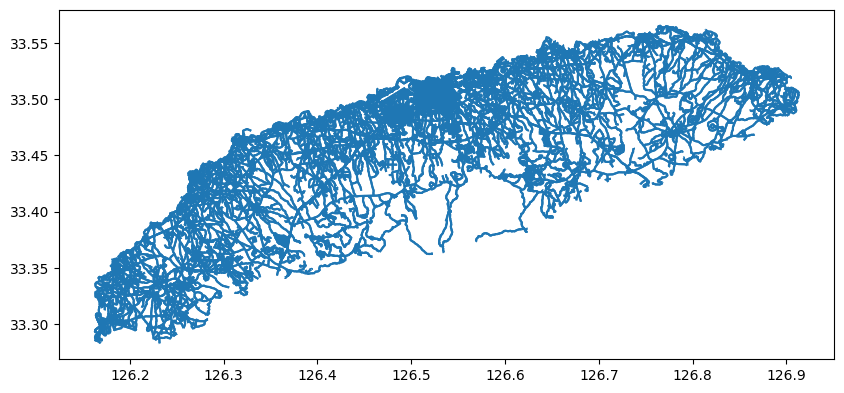

In [20]:
import matplotlib.pyplot as plt
gdf.plot(figsize=(10,10))
plt.show()

In [22]:
from svgpathtools import svg2paths2
import numpy as np
from shapely.geometry import LineString, MultiLineString
import geopandas as gpd
from pathlib import Path
from math import cos, radians

def svg_to_lines(svg_path: str,
                 samples_per_path: int = 400,
                 use_subpaths: bool = True,
                 flip_y: bool = True):
    """
    SVG의 path들을 샘플링하여 화면좌표(x,y) 폴리라인 리스트로 반환
    - viewBox로 정규화하여 (0~1) 범위로 맞춘 뒤 반환
    - flip_y=True면 SVG 스크린 좌표계(y↓)를 수학좌표계(y↑)로 뒤집음
    """
    paths, attrs, svg_attrs = svg2paths2(svg_path)
    vb = svg_attrs.get("viewBox", None)
    if vb:
        x0, y0, w, h = map(float, vb.split())
    else:
        # viewBox가 없으면 width/height 사용 (px)
        w = float(svg_attrs.get("width", 1))
        h = float(svg_attrs.get("height", 1))
        x0, y0 = 0.0, 0.0

    lines = []
    for p in paths:
        # path를 구성하는 연속 구간들을 개별 polyline으로
        subpaths = p.continuous_subpaths() if use_subpaths else [p]
        for sp in subpaths:
            ts = np.linspace(0, 1, samples_per_path)
            xy = np.array([[complex(sp.point(t)).real, complex(sp.point(t)).imag] for t in ts])

            # viewBox 기준 정규화 (0~1)
            x = (xy[:,0] - x0) / w
            y = (xy[:,1] - y0) / h
            if flip_y:  # 화면 y축 아래방향 → 수학좌표계 위쪽
                y = 1 - y

            # 0~1 범위 라인을 LineString으로
            line = LineString(np.column_stack([x, y]))
            if not line.is_empty:
                lines.append(line)

    if not lines:
        return None
    return MultiLineString(lines) if len(lines) > 1 else lines[0]


In [24]:
def normalized_to_wgs84(geom,
                        lon0: float, lat0: float,
                        size_m: float = 1000.0,
                        rotation_deg: float = 0.0):
    """
    (0~1) 정규화 좌표를 중심(lon0,lat0) 주변에 'size_m' 크기로 배치한 WGS84 LineString/MultiLineString 반환
    - size_m: 도형의 가로/세로 평균 크기(미터). 정사각형으로 가정
    - rotation_deg: 시계 반대(+)
    """
    # 중심 기준 [-0.5, 0.5]로 이동
    def _to_xy(arr):
        # arr: (N,2) in [0,1]
        xy = arr - 0.5  # 중심화
        # 회전
        th = radians(rotation_deg)
        R = np.array([[np.cos(th), -np.sin(th)],
                      [np.sin(th),  np.cos(th)]])
        xy = xy @ R.T
        # 미터 스케일
        # 위도 1도 ≈ 111_320 m, 경도 1도 ≈ 111_320 * cos(lat)
        m_per_deg_lat = 111_320.0
        m_per_deg_lon = 111_320.0 * cos(radians(lat0))
        # size_m가 전체 폭(=1.0)에 해당하도록 스케일
        sx_deg = (size_m / m_per_deg_lon)
        sy_deg = (size_m / m_per_deg_lat)
        lon = lon0 + xy[:,0] * sx_deg
        lat = lat0 + xy[:,1] * sy_deg
        return np.column_stack([lon, lat])

    if isinstance(geom, LineString):
        arr = np.array(geom.coords)
        return LineString(_to_xy(arr))
    elif isinstance(geom, MultiLineString):
        return MultiLineString([LineString(_to_xy(np.array(ls.coords))) for ls in geom.geoms])
    else:
        raise TypeError("LineString/MultiLineString만 지원합니다.")


In [28]:
# 입력/출력 경로
SVG = "../data/templates/star.svg"      # ← 네 SVG 경로로 바꿔줘
OUT_DIR = Path("../data/templates"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_GJ = OUT_DIR / "star.geojson"

# 3-1) SVG를 폴리라인으로
geom_norm = svg_to_lines(SVG, samples_per_path=600, use_subpaths=True, flip_y=True)

# 3-2) 제주시 주변에 배치 (중심/크기/회전 조절 가능)
# 제주대학교 공과대학 4호관 좌표
lon0, lat0 = 126.564018, 33.452345   # 공대4호관 중심

geom_wgs = normalized_to_wgs84(
    geom_norm,
    lon0=126.564018,
    lat0=33.452345,
    size_m=3000,        # 8km 뛰기 목표 -> 실제 크기 조절 포인트 
    rotation_deg=0 #필요한 경우 각도 조정
)

gdf = gpd.GeoDataFrame({"name": ["star"]}, geometry=[geom_wgs], crs="EPSG:4326")
gdf.to_file(OUT_GJ, driver="GeoJSON")

In [50]:
#star.geojson은 선(LineString) 하나니까, 이걸 등간격 점들로 분할한 후 → id,lon,lat,timestamp CSV로
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import numpy as np

# 입력 및 출력 파일
GEOJSON = "../data/templates/star.geojson"
CSV_OUT = "../data/network/jeju_walk/gps_star.csv"  # FMM에서 참조한 경로로 저장

# 몇 개의 점으로 샘플링할지 설정
NUM_POINTS = 300

# GeoJSON 로드
gdf = gpd.read_file(GEOJSON)
line: LineString = gdf.geometry[0]

# 등간격 포인트 샘플링
distances = np.linspace(0, line.length, NUM_POINTS)
points = [line.interpolate(d) for d in distances]

# CSV용 데이터프레임 생성
df = pd.DataFrame({
    "id": ["star"] * NUM_POINTS,
    "lon": [p.x for p in points],
    "lat": [p.y for p in points],
    "timestamp": pd.date_range(start="2025-01-01", periods=NUM_POINTS, freq="1s").astype(str)
})

# 저장
df.to_csv(CSV_OUT, index=False)
print(f"✅ Saved: {CSV_OUT}")


✅ Saved: ../data/network/jeju_walk/gps_star.csv


In [34]:
import osmnx as ox
import geopandas as gpd
import numpy as np
from shapely.ops import nearest_points
from pathlib import Path

# --- 좌표계 정의 ---
CRS_WGS84 = "EPSG:4326"
CRS_METRIC = "EPSG:32652"   # 제주도 UTM Zone 52N (미터 단위)

# --- 1. 도보 네트워크 로딩 ---
G = ox.load_graphml("../data/network/jeju_walk/jeju_walk.graphml")
nodes, edges = ox.graph_to_gdfs(G)

# 거리 연산을 위해 EPSG:32652로 변환
nodes_proj = nodes.to_crs(CRS_METRIC)
edges_proj = edges.to_crs(CRS_METRIC)

# --- 2. 템플릿 GeoJSON 로딩 (별 궤적) ---
template = gpd.read_file("../data/templates/star.geojson")
template_proj = template.to_crs(CRS_METRIC)
template_line = template_proj.geometry.iloc[0]  # 단일 궤적 선(LineString)

# --- 3. 노드로 스냅핑하는 함수 ---
def snap_to_nearest_nodes(line, nodes_gdf, n_points=100):
    # 라인 위에서 일정 간격으로 샘플 포인트 생성
    distances = np.linspace(0, line.length, n_points)
    points = [line.interpolate(d) for d in distances]

    snapped_ids = []
    for pt in points:
        # 각 포인트에 대해 가장 가까운 노드의 index 찾기
        nearest_id = nodes_gdf.distance(pt).idxmin()  #node ID!
        snapped_ids.append(nearest_id)

    return snapped_ids

# --- 4. 노드 시퀀스 추출 (예: 100개 지점) ---
snapped_ids = snap_to_nearest_nodes(template_line, nodes_proj, n_points=100)

# --- 5. 확인 출력 ---
print("🔹 스냅된 노드 ID (일부):", snapped_ids[:10])
print("🔹 전체 개수:", len(snapped_ids))


🔹 스냅된 노드 ID (일부): [np.int64(2897246463), np.int64(2897246463), np.int64(2294871471), np.int64(2294871471), np.int64(2294871471), np.int64(3734263322), np.int64(4631888080), np.int64(5325388740), np.int64(3740489760), np.int64(3740489760)]
🔹 전체 개수: 100


In [36]:
import geopandas as gpd
from pathlib import Path

# edges: ox.graph_to_gdfs(G)로 얻은 엣지 GDF라고 가정
# 1) 인덱스(u,v,key)를 컬럼으로 빼오기
edges_cols = edges.reset_index()  # ★ drop 쓰지 마세요

# 2) FMM이 요구하는 컬럼 구성 (source/target/id/geometry)
edges_fmm = edges_cols.rename(columns={"u": "source", "v": "target"}).copy()
edges_fmm["id"] = edges_fmm.index.astype(int)

# 3) (권장) 좌표계 WGS84 확인/변환
edges_fmm = edges_fmm.to_crs(epsg=4326)

# 4) 저장
out = Path("../data/network/jeju_walk"); out.mkdir(parents=True, exist_ok=True)
edges_fmm[["id", "source", "target", "geometry"]].to_file(out / "edges_uv.shp")

print("saved:", (out / "edges_uv.shp").resolve())
print(edges_fmm[["id","source","target"]].head())


saved: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/edges_uv.shp
   id     source       target
0   0  414679035   2823930336
1   1  414679035   2823956648
2   2  414679035   2808553838
3   3  414679035   2823956693
4   4  414679037  12709535501


In [38]:
import geopandas as gpd
from pathlib import Path

# 1. 파일 경로 설정
TEMPLATE_PATH = Path("../data/templates/star.geojson")
EDGES_PATH = Path("../data/network/jeju_walk/edges_uv.shp")
CLIPPED_PATH = Path("../data/network/jeju_walk/edges_uv_clipped.shp")

# 2. 궤적 (별) 로딩 → 미터 좌표계로 변환
template = gpd.read_file(TEMPLATE_PATH).to_crs(epsg=32652)
template_buffer = template.buffer(800)  # ← 800m 반경으로 도로망 자르기

# 3. 도로망 로딩 → 같은 좌표계
edges = gpd.read_file(EDGES_PATH).to_crs(epsg=32652)

# 4. 별 주변만 남기기
clipped = edges[edges.intersects(template_buffer.unary_union)].copy()

# 5. 저장 (WGS84로 다시 변환 후 저장)
clipped = clipped.to_crs(epsg=4326)
clipped.to_file(CLIPPED_PATH)
print(f"✅ 클립 완료! {len(clipped)}개 엣지가 저장됨:", CLIPPED_PATH.resolve())


✅ 클립 완료! 1146개 엣지가 저장됨: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/edges_uv_clipped.shp


/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_5329/1642591283.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  clipped = edges[edges.intersects(template_buffer.unary_union)].copy()


In [42]:
import pandas as pd

df = pd.read_csv("../data/network/jeju_walk/gps_star.csv")

# WKT 형태의 POINT 컬럼 추가
df["geom"] = df.apply(lambda r: f"POINT({r['lon']} {r['lat']})", axis=1)

df.to_csv("../data/network/jeju_walk/gps_star.csv", index=False)
print("✅ geom 컬럼 추가 완료")


✅ geom 컬럼 추가 완료


In [56]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import LineString

# 절대 경로 사용
BASE = "/Users/ieunseo/Desktop/adrenaline-proto"  # 본인 경로로 수정
csv_path = f"{BASE}/data/network/jeju_walk/gps_star.csv"
output_path = f"{BASE}/data/network/jeju_walk/gps_star_trajectory.shp"

# CSV 읽기
gps = pd.read_csv(csv_path)

# WKT → Point 변환
gps['geometry'] = gps['geom'].apply(wkt.loads)

# Trajectory 생성
trajectories = []
for traj_id, group in gps.groupby('id'):
    coords = [(p.x, p.y) for p in group['geometry']]
    line = LineString(coords)
    trajectories.append({'id': traj_id, 'geometry': line})

# 저장
gdf_traj = gpd.GeoDataFrame(trajectories, crs="EPSG:4326")
gdf_traj.to_file(output_path)

print(f"✅ Saved to: {output_path}")
print(f"   Trajectories: {len(trajectories)}")

KeyError: 'geom'

In [58]:
import pandas as pd

BASE = "/Users/ieunseo/Desktop/adrenaline-proto"
csv_path = f"{BASE}/data/network/jeju_walk/gps_star.csv"

# CSV 읽기
gps = pd.read_csv(csv_path)

# 구조 확인
print("Columns:", list(gps.columns))
print("\nFirst 3 rows:")
print(gps.head(3))
print("\nData types:")
print(gps.dtypes)

Columns: ['id', 'lon', 'lat', 'timestamp']

First 3 rows:
     id         lon        lat            timestamp
0  star  126.567205  33.455506  2025-01-01 00:00:00
1  star  126.567352  33.455215  2025-01-01 00:00:01
2  star  126.567691  33.455215  2025-01-01 00:00:02

Data types:
id            object
lon          float64
lat          float64
timestamp     object
dtype: object


In [60]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

BASE = "/Users/ieunseo/Desktop/adrenaline-proto"
csv_path = f"{BASE}/data/network/jeju_walk/gps_star.csv"
output_path = f"{BASE}/data/network/jeju_walk/gps_star_trajectory.shp"

# CSV 읽기
gps = pd.read_csv(csv_path)

print(f"✅ CSV loaded: {len(gps)} rows")

# timestamp 순서로 정렬 (중요!)
gps = gps.sort_values(['id', 'timestamp'])

# id별로 그룹화하여 LineString 생성
trajectories = []
for traj_id, group in gps.groupby('id'):
    coords = list(zip(group['lon'], group['lat']))
    line = LineString(coords)
    trajectories.append({
        'id': traj_id,
        'geometry': line
    })

# GeoDataFrame 생성 및 저장
gdf_traj = gpd.GeoDataFrame(trajectories, crs="EPSG:4326")
gdf_traj.to_file(output_path)

print(f"\n✅ Trajectory Shapefile 생성 완료!")
print(f"   File: {output_path}")
print(f"   Trajectories: {len(trajectories)}")
print(f"   Total points: {len(gps)}")
print(f"   Bounds: {gdf_traj.total_bounds}")

# 거리 계산 (참고용)
line_length_deg = gdf_traj.geometry.iloc[0].length
line_length_km = line_length_deg * 111
print(f"   Total distance: ~{line_length_km:.2f} km")

✅ CSV loaded: 300 rows

✅ Trajectory Shapefile 생성 완료!
   File: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/gps_star_trajectory.shp
   Trajectories: 1
   Total points: 300
   Bounds: [126.55017077  33.44037985 126.57786823  33.4644542 ]
   Total distance: ~11.19 km


Matched columns: ['id', 'cpath', 'mgeom']

First row:
   id                                              cpath  \
0   0  11429,28616,43082,31570,42977,28614,28610,1179...   

                                               mgeom  
0  LINESTRING(126.566906252 33.4554961986,126.566...  

✅ Saved to: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/matched_result.png


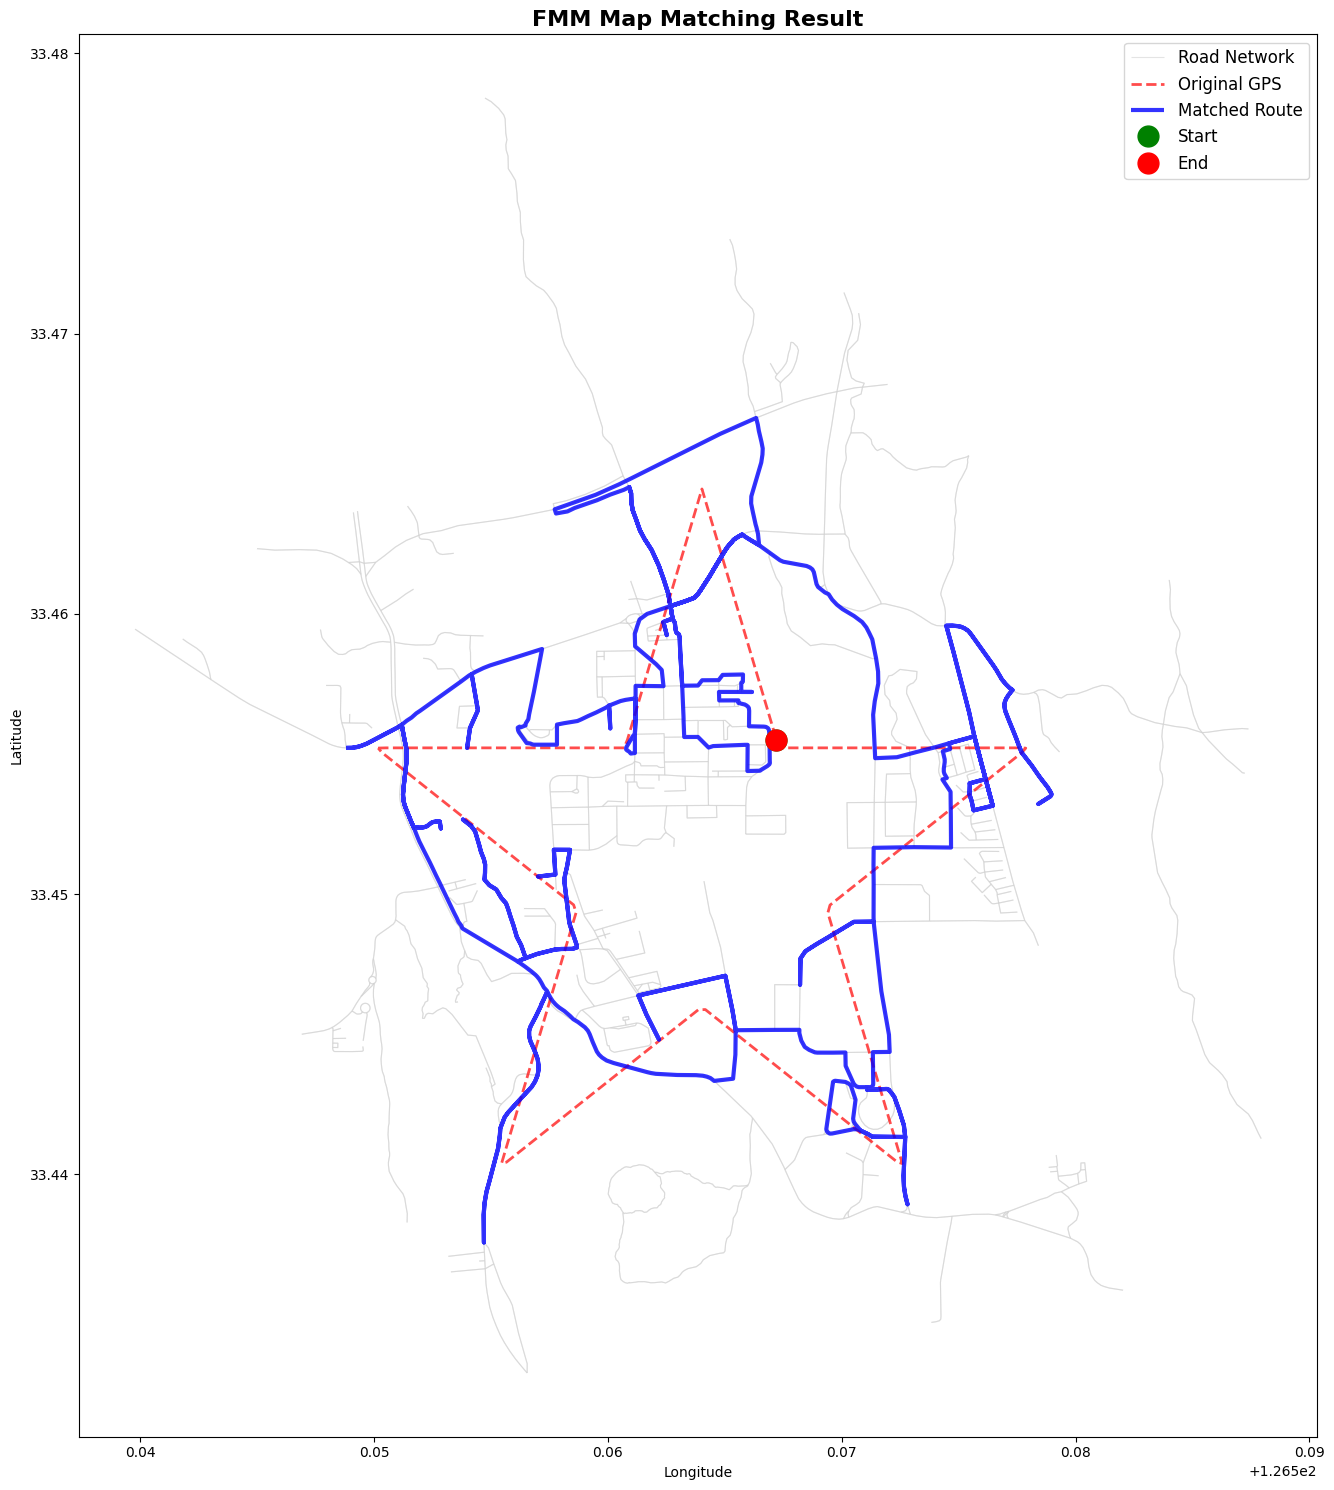

In [62]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

BASE = "/Users/ieunseo/Desktop/adrenaline-proto"

# 매칭 결과 읽기
matched = pd.read_csv(f"{BASE}/data/network/jeju_walk/matched.csv", 
                      delimiter=';')  # FMM은 세미콜론 구분자 사용

print("Matched columns:", list(matched.columns))
print("\nFirst row:")
print(matched.head(1))

# mgeom 컬럼을 geometry로 변환
matched['geometry'] = matched['mgeom'].apply(wkt.loads)
gdf_matched = gpd.GeoDataFrame(matched, geometry='geometry', crs="EPSG:4326")

# 도로망 읽기
network = gpd.read_file(f"{BASE}/data/network/jeju_walk/edges_uv_clipped.shp")

# 원본 GPS 궤적 읽기
gps_traj = gpd.read_file(f"{BASE}/data/network/jeju_walk/gps_star_trajectory.shp")

# 시각화
fig, ax = plt.subplots(figsize=(15, 15))

# 1. 도로망 (회색)
network.plot(ax=ax, color='lightgray', linewidth=0.8, alpha=0.6, label='Road Network')

# 2. 원본 GPS 궤적 (빨강, 점선)
gps_traj.plot(ax=ax, color='red', linewidth=2, linestyle='--', 
              alpha=0.7, label='Original GPS')

# 3. 매칭된 경로 (파랑, 굵게)
gdf_matched.plot(ax=ax, color='blue', linewidth=3, 
                 alpha=0.8, label='Matched Route')

# 시작/끝점 표시
start = gps_traj.geometry.iloc[0].coords[0]
end = gps_traj.geometry.iloc[0].coords[-1]
ax.plot(start[0], start[1], 'go', markersize=15, label='Start', zorder=5)
ax.plot(end[0], end[1], 'ro', markersize=15, label='End', zorder=5)

ax.legend(fontsize=12)
ax.set_title('FMM Map Matching Result', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()

# 저장
plt.savefig(f"{BASE}/data/network/jeju_walk/matched_result.png", dpi=150, bbox_inches='tight')
print(f"\n✅ Saved to: {BASE}/data/network/jeju_walk/matched_result.png")

plt.show()